## UCI Online Retail II – Customer Purchase Behavior Analysis

This project analyzes customer purchasing behavior for a UK-based online retailer using data mining and machine learning techniques. The objective is to extract meaningful customer segments, identify purchasing patterns, and generate actionable marketing recommendations that support data-driven business decisions.

The analysis combines traditional clustering, deep embedding representations, and association rule mining to uncover both high-level customer groups and detailed product-level insights.

By:
**Ainedembe Denis**
- Master's student in Information Systems (2024/2026)
- LinkedIn: https://www.linkedin.com/in/ainedembe-denis-2b329615a/


## Environment Setup
This cell installs and loads all required libraries


In [ ]:
# Install required libraries (run once)

%pip install pandas numpy matplotlib seaborn scikit-learn
%pip install tensorflow
%pip install mlxtend
%pip install tqdm
print(f"Successfully installed required libraries")

In [1]:
# Core Libraries
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing & Feature Engineering
from sklearn.preprocessing import StandardScaler

# Clustering Algorithms
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score

# Dimensionality Reduction (Visualization)
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Deep Learning - Autoencoder for embeddings
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

# Association Rule Mining
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth, apriori, association_rules

# Utilities
import warnings
warnings.filterwarnings("ignore")

# Plot Styling
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (8, 6)
print(f"Successfully imported Libraries")


Successfully imported Libraries


### Part A – Data Cleaning & Clustering

#### A1.1. Load dataset

In [2]:
# Dataset path
file_path = "dataset/online_retail_II.csv"

#Load the dataset with the right encoding
df = pd.read_csv(file_path, encoding='ISO-8859-1')

# Display Shape & the first 10 rows of the DataFrame
print("Shape:", df.shape)
df.head(10)


Shape: (1067371, 8)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
5,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,1.65,13085.0,United Kingdom
6,489434,21871,SAVE THE PLANET MUG,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
7,489434,21523,FANCY FONT HOME SWEET HOME DOORMAT,10,2009-12-01 07:45:00,5.95,13085.0,United Kingdom
8,489435,22350,CAT BOWL,12,2009-12-01 07:46:00,2.55,13085.0,United Kingdom
9,489435,22349,"DOG BOWL , CHASING BALL DESIGN",12,2009-12-01 07:46:00,3.75,13085.0,United Kingdom


#### A1.2. Dataset Information and Statistics

In [3]:
# Display basic information about the dataset
df.info()

# Generate descriptive statistics for numeric and categorical columns
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


,Quantity,Price,Customer ID
count,1.067371e+06,1.067371e+06,824364.000000
mean,9.938898e+00,4.649388e+00,15324.638504
std,1.727058e+02,1.235531e+02,1697.464450
min,-8.099500e+04,-5.359436e+04,12346.000000
25%,1.000000e+00,1.250000e+00,13975.000000
50%,3.000000e+00,2.100000e+00,15255.000000
75%,1.000000e+01,4.150000e+00,16797.000000
max,8.099500e+04,3.897000e+04,18287.000000


#### A2. Cleaning the data
Removing missing descriptions, negative quantities, and cancelled invoices (starting with "C")


In [4]:
df_clean = df.copy()

# Standardise column names if needed (optional, but cleaner)
df_clean.columns = [col.strip().replace(" ", "") for col in df_clean.columns]

# Check new column names
df_clean.columns

# Drop missing Description and Customer_ID
df_clean = df_clean.dropna(subset=["Description", "CustomerID"])

# Remove negative or zero quantities
df_clean = df_clean[df_clean["Quantity"] > 0]

# Remove cancelled invoices - Invoice codes starting with 'C')
df_clean = df_clean[~df_clean["Invoice"].astype(str).str.startswith("C")]

# Create total price column
df_clean["TotalPrice"] = df_clean["Quantity"] * df_clean["Price"]

# Display Shape & the first 5 rows of the cleaned Data
print("Original shape:", df.shape)
print("Cleaned shape:", df_clean.shape)
df_clean.head()


Original shape: (1067371, 8)
Cleaned shape: (805620, 9)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


#### A3. Creating Customer-level features
Looking at total spending, transaction count, avg basket size for clustering analysis.


In [5]:
# Group data by CustomerID & Calculate total spending, transaction count, and total quantity

customer_df = (
    df_clean
    .groupby("CustomerID")
    .agg(
        TotalSpending=("TotalPrice", "sum"),     
        TransactionCount=("Invoice", "nunique"), 
        TotalQty=("Quantity", "sum")
    )
    .reset_index()
)

# Compute Average basket size = total items / number of invoices
customer_df["AvgBasketSize"] = (
    customer_df["TotalQty"] / customer_df["TransactionCount"]
)

# Display the first 10 rows of the Customer DataFrame
customer_df.head(10)


,CustomerID,TotalSpending,TransactionCount,TotalQty,AvgBasketSize
0,12346.0,77556.46,12,74285,6190.416667
1,12347.0,5633.32,8,3286,410.750000
2,12348.0,2019.40,5,2714,542.800000
3,12349.0,4428.69,4,1624,406.000000
4,12350.0,334.40,1,197,197.000000
5,12351.0,300.93,1,261,261.000000
6,12352.0,2849.84,10,724,72.400000
7,12353.0,406.76,2,212,106.000000
8,12354.0,1079.40,1,530,530.000000
9,12355.0,947.61,2,543,271.500000


#### A4. Applying k-Means and DBSCAN clustering + Silhouette scores

In [6]:
# Customer-level features for clustering
features = ["TotalSpending", "TransactionCount", "AvgBasketSize"]
X = customer_df[features].values

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ---- k-Means ----
k = 4  # you can tune this
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
customer_df["kmeans_cluster"] = kmeans.fit_predict(X_scaled)

# ---- DBSCAN ----
dbscan = DBSCAN(eps=0.7, min_samples=5)
customer_df["dbscan_cluster"] = dbscan.fit_predict(X_scaled)

# ---- Silhouette Scores ----
sil_kmeans = silhouette_score(X_scaled, customer_df["kmeans_cluster"])
print(f"k-Means Silhouette Score (k={k}): {sil_kmeans:.4f}")

labels_db = customer_df["dbscan_cluster"].values
valid_mask = labels_db != -1
if len(set(labels_db[valid_mask])) > 1:
    sil_dbscan = silhouette_score(X_scaled[valid_mask], labels_db[valid_mask])
    print(f"DBSCAN Silhouette Score (excluding noise): {sil_dbscan:.4f}")
else:
    print("DBSCAN produced 0 or 1 cluster (besides noise); silhouette not meaningful.")

k-Means Silhouette Score (k=4): 0.9323
DBSCAN Silhouette Score (excluding noise): 0.8754


#### A5. PCA and t-SNE visualizations
5.1 Two Dimension (2D) scatter plots for k-Means and DBSCAN clusters using PCA projections.

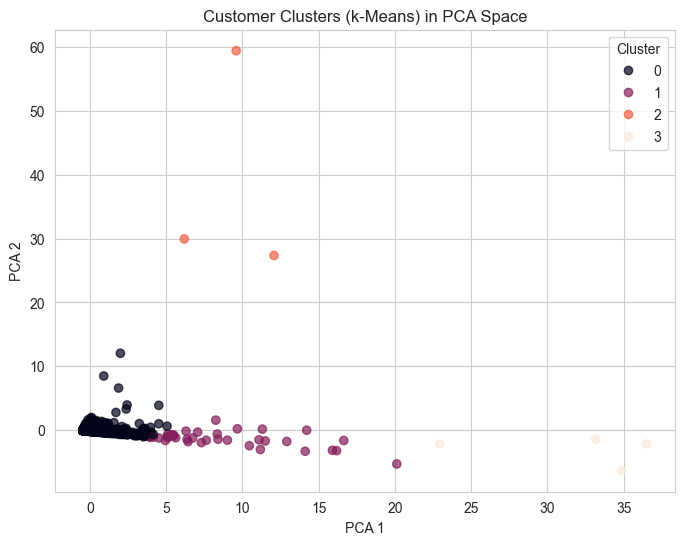

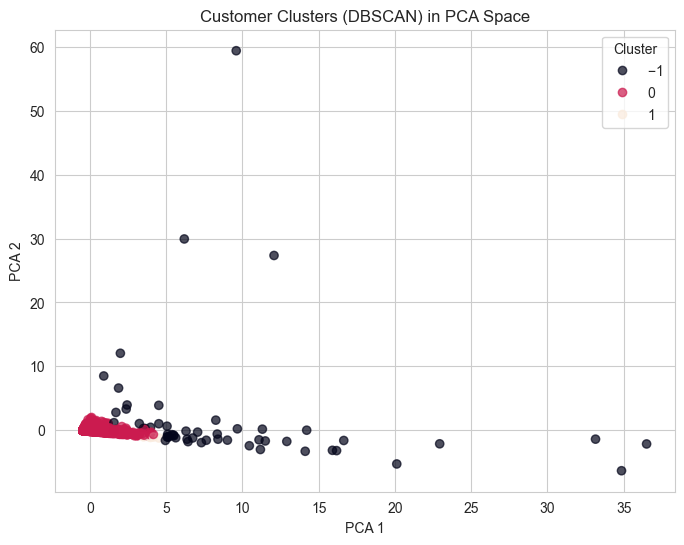

In [7]:
# ---- PCA for 2D visualisation ----
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=customer_df["kmeans_cluster"],
    alpha=0.7
)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Customer Clusters (k-Means) in PCA Space")
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.show()

plt.figure(figsize=(8, 6))
scatter_db = plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=customer_df["dbscan_cluster"],
    alpha=0.7
)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Customer Clusters (DBSCAN) in PCA Space")
plt.legend(*scatter_db.legend_elements(), title="Cluster")
plt.show()


5.2 Two Dimension (2D) scatter plots for k-Means and DBSCAN clusters t-SNE projections.

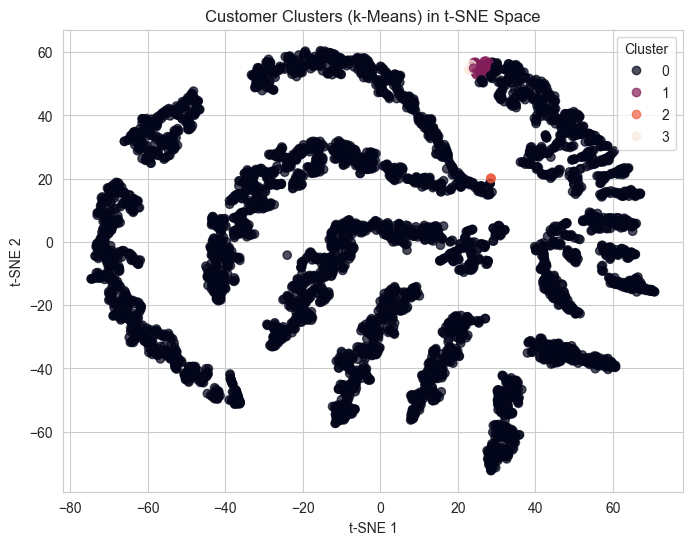

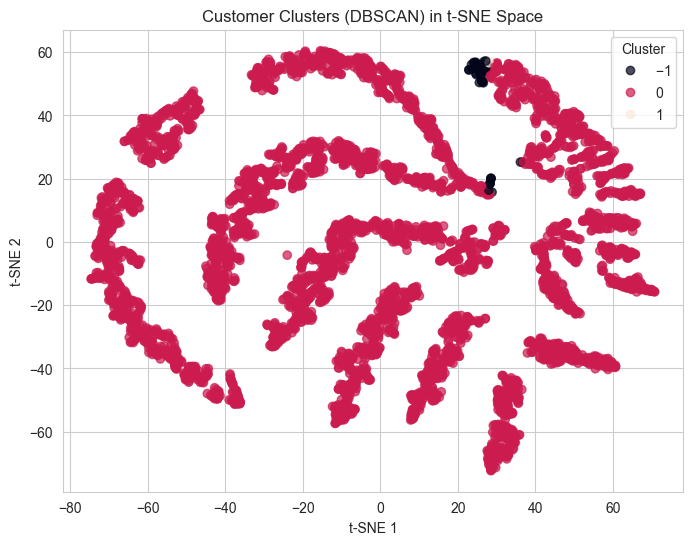

In [8]:
# ---- t-SNE for 2D visualisation ----
# t-SNE is computationally expensive: it scales quadratically with the number of samples (O(n²)). 
# Subsample to keep t-SNE fast on large datasets
max_tsne_samples = 5000
if len(X_scaled) > max_tsne_samples:
    idx = np.random.RandomState(42).choice(len(X_scaled), max_tsne_samples, replace=False)
    X_tsne_input = X_scaled[idx]
    kmeans_labels_tsne = customer_df.iloc[idx]["kmeans_cluster"].values
    dbscan_labels_tsne = customer_df.iloc[idx]["dbscan_cluster"].values
else:
    X_tsne_input = X_scaled
    kmeans_labels_tsne = customer_df["kmeans_cluster"].values
    dbscan_labels_tsne = customer_df["dbscan_cluster"].values

tsne = TSNE(n_components=2, random_state=42, perplexity=30, init="pca", learning_rate="auto")
X_tsne = tsne.fit_transform(X_tsne_input)

plt.figure(figsize=(8, 6))
scatter_tsne_k = plt.scatter(
    X_tsne[:, 0],
    X_tsne[:, 1],
    c=kmeans_labels_tsne,
    alpha=0.7
)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title("Customer Clusters (k-Means) in t-SNE Space")
plt.legend(*scatter_tsne_k.legend_elements(), title="Cluster")
plt.show()

plt.figure(figsize=(8, 6))
scatter_tsne_db = plt.scatter(
    X_tsne[:, 0],
    X_tsne[:, 1],
    c=dbscan_labels_tsne,
    alpha=0.7
)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title("Customer Clusters (DBSCAN) in t-SNE Space")
plt.legend(*scatter_tsne_db.legend_elements(), title="Cluster")
plt.show()

### Part B – Deep Embedding Clustering (Autoencoder)
Here we build an autoencoder on X_scaled, get latent embeddings, then cluster them with k-Means and plot.


#### B1.1. Autoencoder architecture

In [9]:
# Autoencoder architecture
input_dim = X_scaled.shape[1]
encoding_dim = 2  # bottleneck size - for easy plotting

input_layer = layers.Input(shape=(input_dim,))
encoded = layers.Dense(8, activation="relu")(input_layer)
bottleneck = layers.Dense(encoding_dim, activation="relu", name="bottleneck")(encoded)
decoded = layers.Dense(8, activation="relu")(bottleneck)
output_layer = layers.Dense(input_dim, activation="linear")(decoded)

autoencoder = models.Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer="adam", loss="mse")

autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 2)              │            18 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101 (404.00 B)

 Trainable params: 101 (404.00 B)

 Non-trainable params: 0 (0.00 B)

#### B1.2. Train autoencoder

Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.8386 - val_loss: 1.5959
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8182 - val_loss: 1.5771
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7978 - val_loss: 1.5573
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7743 - val_loss: 1.5338
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7459 - val_loss: 1.5086
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7190 - val_loss: 1.4826
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6909 - val_loss: 1.4571
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6603 - val_loss: 1.4242
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6315 - val_loss: 1.3939
Epoch 10/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6016 - val_loss: 1.3675
Epoch 11/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5752 - val_loss: 1.3432
Epoch 12/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5568 - val_lo

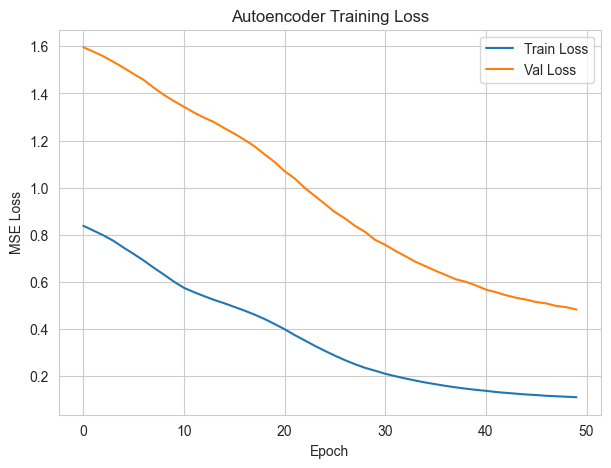

In [10]:
history = autoencoder.fit(
    X_scaled, X_scaled,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    verbose=1
)

# Plot training loss
plt.figure(figsize=(7, 5))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Autoencoder Training Loss")
plt.legend()
plt.show()


#### B2. Getting embeddings and clustering & Compare cluster quality
B2.1. Extract latent embeddings from the trained autoencoder and apply k-Means clustering and Visualising latent space

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Autoencoder Embedding k-Means Silhouette Score: 0.8086


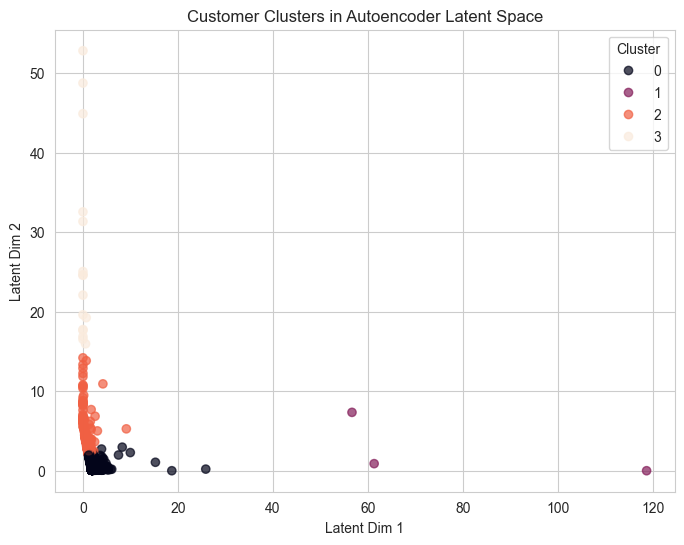

In [13]:
# Extract encoder part
encoder = models.Model(inputs=autoencoder.input,
                outputs=autoencoder.get_layer("bottleneck").output)

embeddings = encoder.predict(X_scaled)

# k-Means on latent space
kmeans_ae = KMeans(n_clusters=k, random_state=42, n_init=10)
customer_df["ae_cluster"] = kmeans_ae.fit_predict(embeddings)

sil_ae = silhouette_score(embeddings, customer_df["ae_cluster"])
print(f"Autoencoder Embedding k-Means Silhouette Score: {sil_ae:.4f}")

# Embedding plots and compareing cluster quality with PCA clusters.
plt.figure(figsize=(8, 6))
scatter_ae = plt.scatter(embeddings[:, 0], embeddings[:, 1],
                         c=customer_df["ae_cluster"], alpha=0.7)
plt.xlabel("Latent Dim 1")
plt.ylabel("Latent Dim 2")
plt.title("Customer Clusters in Autoencoder Latent Space")
plt.legend(*scatter_ae.legend_elements(), title="Cluster")
plt.show()



B2.2. Silhouette Score Comparison on clustering quality: k-Means on PCA vs Autoencoder embeddings

In [17]:
# Apply PCA (2D for comparison with autoencoder latent space)
pca_2d = PCA(n_components=2, random_state=42)
X_pca_2d = pca_2d.fit_transform(X_scaled)

# Apply k-Means on PCA-reduced features
kmeans_pca = KMeans(n_clusters=k, random_state=42, n_init=10)
customer_df["kmeans_pca_cluster"] = kmeans_pca.fit_predict(X_pca_2d)

# Compute silhouette scores
sil_pca = silhouette_score(X_pca_2d, customer_df["kmeans_pca_cluster"])
sil_ae = silhouette_score(embeddings, customer_df["ae_cluster"])

# Display comparison
print("SILHOUETTE SCORE COMPARISON")
print("_" * 45)
print(f"k-Means on PCA (2D):        {sil_pca:.4f}")
print(f"k-Means on Autoencoder embeddings: {sil_ae:.4f}")
print("-" * 45)
print(f"Difference:                  {abs(sil_ae - sil_pca):.4f}")
if sil_ae > sil_pca:
    print(f"Autoencoder embeddings perform better by {((sil_ae - sil_pca) / sil_pca * 100):.2f}%")
else:
    print(f"PCA performs better by {((sil_pca - sil_ae) / sil_ae * 100):.2f}%")


SILHOUETTE SCORE COMPARISON
_____________________________________________
k-Means on PCA (2D):        0.8351
k-Means on Autoencoder embeddings: 0.8086
---------------------------------------------
Difference:                  0.0265
PCA performs better by 3.27%


### Part C – Association Rule Mining
Extract frequent itemsets and association rules from transactional data to discover product relationships.


#### C1 & C2. Basket format and binary matrix

In [18]:
# Convert data into basket format: Invoice to a list of Description items.
# Build binary matrix with Invoice as rows and Description as columns

# Use cleaned transactional data
basket_df = (
    df_clean[["Invoice", "Description", "Quantity"]]
    .copy()
)

# We only care whether an item was bought (not quantity)
basket_df["Quantity"] = basket_df["Quantity"].astype(int)

# Create basket: rows = Invoice, columns = Description (1/0)
basket = (
    basket_df
    .groupby(["Invoice", "Description"])["Quantity"]
    .sum()
    .unstack()
    .fillna(0)
)

# Convert to 0/1
basket_bool = basket.applymap(lambda x: 1 if x > 0 else 0)

basket_bool.head()


Description,DOORMAT UNION JACK GUNS AND ROSES,3 STRIPEY MICE FELTCRAFT,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,ANIMAL STICKERS,BLACK PIRATE TREASURE CHEST,BROWN PIRATE TREASURE CHEST,Bank Charges,CAMPHOR WOOD PORTOBELLO MUSHROOM,CHERRY BLOSSOM DECORATIVE FLASK,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
Invoice,,,,,,,,,,,,,,,,,,,,,
489434,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
489435,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
489436,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
489437,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
489438,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Verification: Check that the binary matrix contains purchases (1s)

In [22]:
# Verification: Check that the binary matrix contains purchases (1s)
print("BASKET MATRIX VERIFICATION")
print("_" * 90)
print(f"Matrix shape: {basket_bool.shape[0]} invoices × {basket_bool.shape[1]} products")
print(f"\nTotal purchases (sum of all 1s): {basket_bool.sum().sum():,}")
print(f"Total possible entries: {basket_bool.size:,}")
print(f"Sparsity: {(1 - basket_bool.sum().sum() / basket_bool.size) * 100:.2f}% (expected for retail data)")

print(f"\nInvoices with at least one purchase: {(basket_bool.sum(axis=1) > 0).sum():,}")
print(f"Products purchased at least once: {(basket_bool.sum(axis=0) > 0).sum():,}")

# Show sample invoices with purchases
print(f"\nSample invoices with purchases:")
sample_invoices = basket_bool[basket_bool.sum(axis=1) > 0].head(5)
for invoice in sample_invoices.index:
    items = basket_bool.columns[basket_bool.loc[invoice] == 1].tolist()
    print(f"  Invoice {invoice}: {len(items)} items")
    if len(items) > 0:
        print(f"    Sample items: {', '.join(items[:2])}{'...' if len(items) > 3 else ''}")


BASKET MATRIX VERIFICATION
__________________________________________________________________________________________
Matrix shape: 36975 invoices × 5283 products

Total purchases (sum of all 1s): 768,619
Total possible entries: 195,338,925
Sparsity: 99.61% (expected for retail data)

Invoices with at least one purchase: 36,975
Products purchased at least once: 5,283

Sample invoices with purchases:
  Invoice 489434: 8 items
    Sample items:  WHITE CHERRY LIGHTS, 15CM CHRISTMAS GLASS BALL 20 LIGHTS...
  Invoice 489435: 4 items
    Sample items: CAT BOWL , DOG BOWL , CHASING BALL DESIGN...
  Invoice 489436: 19 items
    Sample items:  PEACE WOODEN BLOCK LETTERS, AREA PATROLLED METAL SIGN...
  Invoice 489437: 23 items
    Sample items: BLUE PADDED SOFT MOBILE, CHOCOLATE HOT WATER BOTTLE...
  Invoice 489438: 17 items
    Sample items: CARROT CHARLIE+LOLA COASTER SET, CHARLIE & LOLA WASTEPAPER BIN BLUE...


#### C3 & C4. Apply FP-Growth and extract 10 strongest rules by lift
Apply FP-Growth algorithm to find frequent itemsets, then generate association rules and extract the top 10 rules sorted by lift.


In [ ]:
# Apply FP-Growth - more memory-efficient than Apriori for large datasets

# Extract the 10 strongest rules sorted by lift.
# FP-Growth to get frequent itemsets
frequent_itemsets = fpgrowth(
    basket_bool,
    min_support=0.01,        # tune depending on runtime/size
    use_colnames=True
)

print("Number of frequent itemsets:", len(frequent_itemsets))
frequent_itemsets.head(10)


Number of frequent itemsets: 719


,support,itemsets
0,0.049168,(STRAWBERRY CERAMIC TRINKET BOX)
1,0.016227,(SAVE THE PLANET MUG)
2,0.012955,(PINK DOUGHNUT TRINKET POT )
3,0.011684,(15CM CHRISTMAS GLASS BALL 20 LIGHTS)
4,0.071724,(ASSORTED COLOUR BIRD ORNAMENT)
5,0.049520,(HOME BUILDING BLOCK WORD)
6,0.040162,(LOVE BUILDING BLOCK WORD)
7,0.039405,(SCOTTIE DOG HOT WATER BOTTLE)
8,0.019986,(HEART IVORY TRELLIS LARGE)
9,0.018824,(AREA PATROLLED METAL SIGN)


Generating association rules

In [28]:
# Generate association rules from frequent itemsets
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

# Sort by lift and get top 10 strongest rules
top_rules = rules.sort_values("lift", ascending=False).head(10)

print("TOP 10 STRONGEST ASSOCIATION RULES (by Lift)")
print("_" * 105)
print(f"\nTotal rules generated: {len(rules)}")
print(f"\nTop 10 rules:\n")
print(top_rules[["antecedents", "consequents", "support", "confidence", "lift"]].to_string())


TOP 10 STRONGEST ASSOCIATION RULES (by Lift)
_________________________________________________________________________________________________________

Total rules generated: 394

Top 10 rules:

                         antecedents                      consequents   support  confidence       lift
377     (POPPY'S PLAYHOUSE BEDROOM )  (POPPY'S PLAYHOUSE LIVINGROOM )  0.010331    0.687050  55.225407
376  (POPPY'S PLAYHOUSE LIVINGROOM )     (POPPY'S PLAYHOUSE BEDROOM )  0.010331    0.830435  55.225407
374  (POPPY'S PLAYHOUSE LIVINGROOM )      (POPPY'S PLAYHOUSE KITCHEN)  0.011034    0.886957  53.238989
375      (POPPY'S PLAYHOUSE KITCHEN)  (POPPY'S PLAYHOUSE LIVINGROOM )  0.011034    0.662338  53.238989
372      (POPPY'S PLAYHOUSE KITCHEN)     (POPPY'S PLAYHOUSE BEDROOM )  0.012765    0.766234  50.955924
373     (POPPY'S PLAYHOUSE BEDROOM )      (POPPY'S PLAYHOUSE KITCHEN)  0.012765    0.848921  50.955924
133    (SET/6 RED SPOTTY PAPER CUPS)  (SET/6 RED SPOTTY PAPER PLATES)  0.013225    0

#### C5. Pick at least 3 rules to interpret
Display the top 3 association rules in a readable format for interpretation and analysis.


In [34]:
# Convert frozen sets to readable strings
def frozenset_to_str(fset):
    return ", ".join(list(fset))

print("TOP 4 ASSOCIATION RULES FOR INTERPRETATION")
print("_" * 120)
print()

for idx, row in top_rules.head(4).iterrows():
    antecedents = frozenset_to_str(row["antecedents"])
    consequents = frozenset_to_str(row["consequents"])
    print(f"Rule {idx+1}: IF a customer buys [{antecedents}] THEN they also tend to buy [{consequents}]")
    print(f"  Support:   {row['support']:.4f}")
    print(f"  Confidence: {row['confidence']:.4f}")
    print(f"  Lift:      {row['lift']:.4f}")
    print("-" * 120)


TOP 4 ASSOCIATION RULES FOR INTERPRETATION
________________________________________________________________________________________________________________________

Rule 378: IF a customer buys [POPPY'S PLAYHOUSE BEDROOM ] THEN they also tend to buy [POPPY'S PLAYHOUSE LIVINGROOM ]
  Support:   0.0103
  Confidence: 0.6871
  Lift:      55.2254
------------------------------------------------------------------------------------------------------------------------
Rule 377: IF a customer buys [POPPY'S PLAYHOUSE LIVINGROOM ] THEN they also tend to buy [POPPY'S PLAYHOUSE BEDROOM ]
  Support:   0.0103
  Confidence: 0.8304
  Lift:      55.2254
------------------------------------------------------------------------------------------------------------------------
Rule 375: IF a customer buys [POPPY'S PLAYHOUSE LIVINGROOM ] THEN they also tend to buy [POPPY'S PLAYHOUSE KITCHEN]
  Support:   0.0110
  Confidence: 0.8870
  Lift:      53.2390
---------------------------------------------------------